# Estimate mean and variance of an algebraic function using PCE and MC
## Model Response: $y=f(q)$  where $q\sim \mathcal{U}[\mathbb{Q}]$, estimate $\mathbb{E}(f)$ and $\mathbb{V}(f)$
## FLOW/INTERFACE Winter School, Dec. 2019
S. Rezaeiravesh, salehr@kth.se

In [1]:
import math as mt
import numpy as np
from numpy.polynomial import legendre
import matplotlib.pyplot as plt

## Model function with one uncertain parameter, 
## $ f(q)=10+0.7\sin(5q)+3\cos(q)$
## and, analytical expressions for its mean and variance for $q\sim\mathcal{U}[\mathbb{Q}]$. 

In [2]:
def fEx1D(z):  
    """ 
       Analytical function over a 1D parameter space
    """
    z = np.array(z, copy=False, ndmin=1)
    val=(10.0+.7*np.sin(5.0*z)+3.*np.cos(z))
    val=np.array(val)
    return val

def fEx1D_moments(qBound):
    """ Mean and Variance of fEx1D(z) """
    def mean_(q_):
        return (10.*q_-0.7*mt.cos(5.*q_)/5.0+3.*mt.sin(q_))
    def var_(q_):
        tmp=100*q_+0.245*(q_-0.1*mt.sin(10*q_))+4.5*(q_+0.5*mt.sin(2*q_))
        return (tmp-2.8*mt.cos(5*q_)+60*mt.sin(q_)-2.1*(mt.cos(6*q_)/6.+0.25*mt.cos(4*q_)))                                             
    fMean=(mean_(qBound[1])-mean_(qBound[0]))/(qBound[1]-qBound[0])                 
    fVar =(var_(qBound[1])-var_(qBound[0]))/(qBound[1]-qBound[0])-fMean**2.                                                               
    return fMean,fVar            

## Model function with two uncertain parameters:
## $f(q_1,q_2)=100(q_2-q_1^2)^2+(1-q_1)^2.$

In [16]:
def rosenbrock(q1,q2):
    """
        Rosenbrock function over a 2D parameter space
    """
    f=100*(q2-q1**2.)**2.+(1-q1)**2.
    return f

## Gauss-Legendre Quadrature Rule: nodes $\in[-1,1]$ and weights

In [17]:
def GaussLegendreRule(n):
    """
       Returns n Gauss-Legendre quadrature points and associated weights
    """
    x=legendre.leggauss(n)
    quads=x[0]
    weights=x[1]
    return quads,weights

## Legendre polynomials: $\psi_k(\xi)$ for $\xi\in[-1,1]$

In [18]:
def legendreEval(xi,k):
    """
       Evaluate Legendre polynomial of order k at xi\in[-1,1]
    """
    return legendre.legval(xi,[0]*k+[1])

## Construct the PCE $\tilde{f}(\xi) = \sum_{k=0}^K \hat{f}_k \psi_k(\xi)$ for $\xi\in \mathbb{Q}\subset \mathbb{R}$
## Given, $\{f(q^k)\}_{k=1}^{K+1}$, we compute $\{\hat{f}_k\}_{k=0}^K$ using Gauss-Legendre rule. 
## >>> Task 1. Complete the missing lines to estimate mean and variance of the model response by $\mathbb{E}[f]=\hat{f}_0$ and $\mathbb{V}[f]=\sum_{k=1}^K \hat{f}^2_k \gamma_k$ where, $\gamma_k = \langle \psi_k(\xi),\psi_k(\xi) \rangle_\rho$

In [19]:
def pce1D(qBound,nGQ,nTest):
    """
       Test PCE for 1D parameter space
          nGQ: number of deterministic samples in the parameter space
          nTest: number of test samples (for plotting)
    """ 
    #1. Choose the parameter samples  
    xi,w=GaussLegendreRule(nGQ)  
    gQ=(0.5*(xi+1.0)*(qBound[1]-qBound[0])+qBound[0])  
    fgQ=fEx1D(gQ)  #model response at parameter samples
    
    #2. Compute the coefficients in PCE
    fHat=np.zeros(nGQ)
    varTmp=[]
    for k in range(nGQ): 
        psi_k=legendreEval(xi,k)
        num=fgQ*psi_k*w
        den=psi_k*psi_k*w
        fHat[k]=sum(num)/sum(den)   #coeffcients in the expansion
        varTmp.append(0.5*sum(den))
        
    # Task 1. Estimate the mean and variance by PCE
    #fMean=???
    #fVar=???
    
    #4. Use the PCE as predictor at test points
    qTest=np.linspace(qBound[0],qBound[1],nTest)    
    sum_=np.zeros(nTest)
    xiTest=(2.*(qTest-qBound[0])/(qBound[1]-qBound[0])-1.)        
    for i in range(nGQ):
        sum_+=fHat[i]*legendreEval(xiTest,i)
    fPCE=sum_
    
    #5. Plot        
    fExact=fEx1D(qTest)   #exact response    
    plt.figure(figsize=[9,6]) 
    plt.plot(qTest,fExact,'-b',lw=2,label=r'$f(q)$')
    plt.plot(gQ,fgQ,'or')
    plt.plot(qTest,fPCE,'--r',lw=2,label=r'$\tilde{f}_{pce}(q)$')
    plt.legend(loc='best',fontsize=20)
    plt.xlabel(r'$q$',fontsize=17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.show()
    return fMean,fVar

## Monte Carlo Estimator

In [7]:
def MC_1d(nMC,qBound):
    """
    Monte Carlo Mean and Variance Estimator
       nMC: no. of MC samples
    """    
    q=np.random.uniform(low=qBound[0], high=qBound[1], size=[nMC]) 
    fMC=fEx1D(q)
    Emc=np.mean(fMC)
    Vmc=np.mean(fMC**2.)-Emc**2.
    return Emc,Vmc

## >>> Task 2. Compare estimated mean and variance from PCE and MC methods

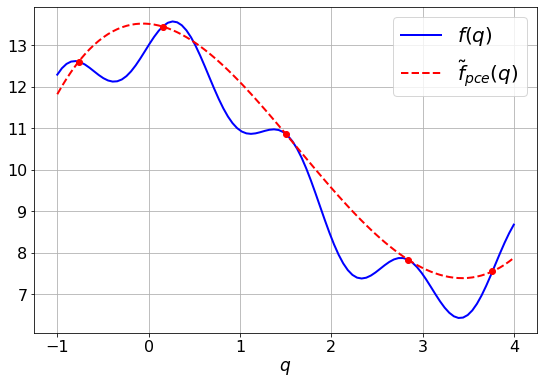

Estimated E[f] and V[f]
Exact:	 10.047317337162177 5.665611826408181
PCE:	 10.571521988200738 5.385176794426807
MC:	 9.443980240847537 5.6076137849246805


In [8]:
#----- SETTINGS
qBound=[-1,4]      #admissible range of parameter
nGQ=5             #number of data samples for PCE = quadrature points
nMC=100         #number of Monte Carlo Samples
nTest=100        #number of test points
#---------------------------------------
#---------------------------------------
#exact moments
E_ex,V_ex=fEx1D_moments(qBound)
#moments by PCE
E_pce,V_pce=pce1D(qBound,nGQ,nTest)
#moments by MC
E_mc,V_mc=MC_1d(nMC,qBound)

print('Estimated E[f] and V[f]')
print('Exact:\t', E_ex,V_ex)
print('PCE:\t',E_pce,V_pce)
print('MC:\t',E_mc,V_mc)

# Task 2. Investiagte the convergence of estimated statsitics by PCE and MC
# ????

## Plot surface reponse in 2D parameter space

In [20]:
def surfacePlot_GQ(qGrid1,qGrid2,fG,qGQ):
    """
       2D plot of response surface fG in plane of qGrid+
       representation of the GQs
    """
    plt.figure(figsize=[8,8])
    ax=plt.gca()
    CS = plt.contour(qGrid1,qGrid2,fG,40,cmap='jet')
    plt.clabel(CS, inline=True, fontsize=16,colors='k',fmt='%d',rightside_up=True,manual=False)
    plt.plot(qGQ[:,0],qGQ[:,1],'ok',markersize=8)
    plt.xlabel(r'$q_1$',fontsize=23) 
    plt.ylabel(r'$q_2$',fontsize=23)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [10]:
def vecs2grid(x,y):
    """
        Make a 2D tensor product grid z out of two 1D vectors x and y
            x: a numpy 1D array or a 1D list of length nx
            y: a numpy 1D array or a 1D list of length ny
            z: numpy 2D array (nx*ny,2) 
    """
    nx=x.shape[0]
    ny=y.shape[0]
    z=np.zeros((nx*ny,2))
    for iy in range(ny):
        for ix in range(nx):
            iz=iy*nx+ix
            z[iz,0]=x[ix]
            z[iz,1]=y[iy]
    return z

In [11]:
def plot2D_gridVals(x1,x2,f):
    """
       Reads in numpy arrays
          x1: n1x1
          x2: n2x1
          f: (n1*n2)x1 or n1xn2
       and returns a 2D grid 
          xG1: n1xn2
          xG2: n1xn2
          fG: n1xn2
       Note: in converting f->fG it is always assumed that param2 has the outer loop.
    """
    n1=x1.shape[0] 
    n2=x2.shape[0] 
    xG1=np.zeros((n1,n2))
    xG2=np.zeros((n1,n2))
    fG=np.zeros((n1,n2))
    f_convert=True
    if f.ndim==2 and f.shape[0]==n1 and f.shape[1]==n2:
       fG=f  #in case the imported f is already n1xn2
       f_convert=False
    for i2 in range(n2):
        for i1 in range(n1):
            k=i2*n1+i1
            xG1[i1,i2]=x1[i1]          
            xG2[i1,i2]=x2[i2]          
            if (f_convert):
               fG[i1,i2]=f[k]
    return xG1,xG2,fG

## Construct PCE over the 2D parameter space $[-2,2]^2$
## >>> Task 3. Compute coeffcients $\{\hat{f}_k\}_{k=0}^K$ (Hint: look at the code for PCE for 1D parameter)

In [12]:
def PCE2D_TP_constructor(nGQ,xi,w,fGQ):
    """
       Construct a PCE for 2D uncertain parameter based on tensor product rule       
    """
    xi1=xi[0]
    w1=w[0]
    xi2=xi[1]
    w2=w[1]
    K=nGQ[0]*nGQ[1]; 

    #find the coefficients in PCE
    fHat=np.zeros(K)
    sum2=[]
    for k2 in range(nGQ[1]):  
        psi_k2=legendreEval(xi2,k2)
        for k1 in range(nGQ[0]):  
            psi_k1=legendreEval(xi1,k1)
            sum1=0.0
            sum2_=0.0
            k=k2*nGQ[0]+k1
            for j2 in range(nGQ[1]):
                for j1 in range(nGQ[0]):
                    j=j2*nGQ[0]+j1
                    #Task 3. (4 missing lines)
                    # ???
                    # ???
            fHat[k]=#???
            #sum2.append(???)
    #The mean and variance of f(q) estimated by PCE
    fMean=fHat[0]
    fVar=0.0
    for k in range(1,K):
        fVar+=fHat[k]*fHat[k]*sum2[k]
    return fHat,fMean,fVar

## Evaluation of a PCE at a 2D test parameter

In [13]:
def pce_LegUnif_2d_eval(fk,nQ1,nQ2,xi1,xi2):
    """ 
       Evaluate a 2D PCE at a set of test points xi1,xi2\in[-1,1] which are assumed to make a tensor-product grid
       Uniform Uncertain Parameter
       => Legendre Polynomials
          Given {f_k}, find f(q)=\sum_k f_k psi_k(q) 
       #NOTE: assumes Tensor product
    """
    xi1 = np.array(xi1, copy=False, ndmin=1)
    xi2 = np.array(xi2, copy=False, ndmin=1)
    n1=xi1.size
    n2=xi2.size
    fpce=np.zeros((n1,n2))
    for i2 in range(n2):
        for i1 in range(n1):
            sum1=0.0;
            for k2 in range(nQ2):
                for k1 in range(nQ1):
                    k=k2*nQ1+k1
                    sum1+=fk[k]*legendreEval(xi1[i1],k1)*legendreEval(xi2[i2],k2)
            fpce[i1,i2]=sum1        
    return fpce

## Test PCE for a 2D parameter space

In [14]:
def pce2D_test(nGQ,iPlot):
    """
        Test PCE for a 2D parameter space
    """
    #----- settings
    qBound=[[-2,2],[-2,2]]   #range of parameters q1, q2
    nTest=[50,50]            #no. of test points (for plot)
    #------------------------------------
    p=len(qBound)    
    #1. Choose the parameter samples 
    xi=[]
    w=[]
    qGQ=[]
    for i in range(p):
        xi_,w_=GaussLegendreRule(nGQ[i])
        xi.append(xi_)
        w.append(w_)
        qGQ.append((0.5*(xi_+1.0)*(qBound[i][1]-qBound[i][0])+qBound[i][0]))
    qGQgrid=vecs2grid(qGQ[0],qGQ[1])              
    fGQgrid=rosenbrock(qGQgrid[:,0],qGQgrid[:,1])
    
    #2. Construct the PCE and esimate statistical moments of f
    fCoef,fMean,fVar=PCE2D_TP_constructor(nGQ,xi,w,fGQgrid)
    
    #3. Plot the surface perdicted by PCE
    if iPlot:
       #   generate test points in the parameter space
       qTest=[]
       xiTest=[]
       for i in range(p):
          qTest.append(np.linspace(qBound[i][0],qBound[i][1],nTest[i]))
          xiTest.append(2.*(qTest[i]-qBound[i][0])/(qBound[i][1]-qBound[i][0])-1.)
       fPCETest=pce_LegUnif_2d_eval(fCoef,nGQ[0],nGQ[1],xiTest[0],xiTest[1])
       q1Plot,q2Plot,fPlot_=plot2D_gridVals(qTest[0],qTest[1],fPCETest)
       surfacePlot_GQ(q1Plot,q2Plot,fPCETest,qGQgrid) 
    return fMean,fVar

## Test PCE for Rosenbrock function with 2 uncertain parameters 

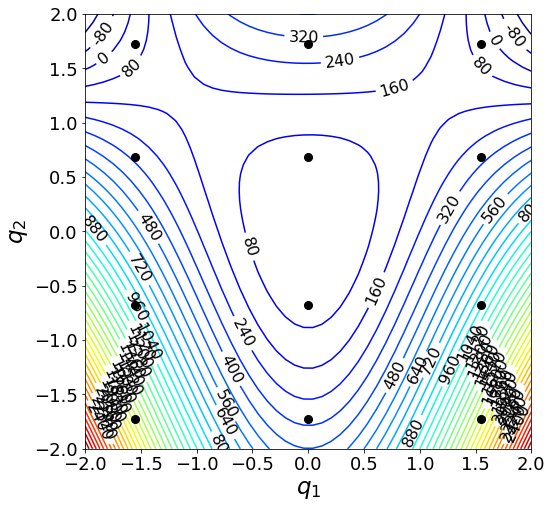

Mean(f)=  455.66666666666686
Var(f)=  267498.3111111111


In [15]:
fMean,fVar=pce2D_test([3,4],iPlot=True)
print('Mean(f)= ',fMean)
print('Var(f)= ',fVar)